# Gradient verification for the 1D - non reactive transport (diffusion + advection), permeability inversion from head observations 

The goal here is to verify the correctness of the adjoint state method in HYTEC by comparing the results with the demonstrator's which are considered as correct.

In [1]:
from pathlib import Path
import os
import logging
import copy
from typing import Generator, Iterable
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
from pyrtid.utils import indices_to_node_number, node_number_to_indices
import nested_grid_plotter as ngp
import scipy as sp
from pyrtid.plot import plot_observed_vs_simulated
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.animation import HTMLWriter
from IPython.display import HTML
from nested_grid_plotter import make_y_axes_symmetric_zero_centered
import numpy as np
import gstools as gs
from pyrtid.utils import (
    NDArrayFloat,
    NDArrayInt,
    gen_random_ensemble,
    node_number_to_indices,
)
import copy

gs.config.USE_RUST = True  # Use the rust implementation of gstools

- Set-up logging level

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a test")

INFO:root:this is a test


- Check package/software versions

In [3]:
pyrtid.utils.show_versions()

INFO:root:Current version = 0.1.2

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.1
INFO:root:matplotlib                  = 3.8.3
INFO:root:nested_grid_plotter         = 1.1.2
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.25.2
INFO:root:pyesmda                     = 0.4.3
INFO:root:pypcga                      = 0.1.0
INFO:root:scipy                       = 1.10.1
INFO:root:sksparse                    = 0.4.12
INFO:root:stochopy                    = 2.3.0


- Create a directory to store the exported figures

In [4]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [5]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

## Forward problem

- Define a very simple pure diffusion case in 1D.

In [6]:
nx = 40  # number of voxels along the x axis
ny = 1  # number of voxels along the y axis
dx = 9.3  # voxel dimension along the x axis
dy = 8.45  # voxel dimension along the y axis

# Time parameters
duration_in_d = 7.0  # duration in days
duration_in_s = duration_in_d * 3600 * 24
dt_init = 3600 * 6  # timestep in seconds
dt_max = dt_init
dt_min = dt_init

c0 = 0  # general initial cocentration
# Hydro parameters
D0 = 1e-4  # general initial diffusion coefficient [m2/s]
k0 = 1e-4  # general permeability
w0 = 0.23  # general porosity [fraction]
# Chemistry parameters
c0 = 0.0  # general initial concentration [molal]
c_inj = 1e-5  # molal
storage_coefficient = 1e-3
# Values for the x axis ()meters
x_positions_in_meters: NDArrayFloat = np.arange(nx) * dx + dx / 2

In [7]:
x_positions_in_meters

array([  4.65,  13.95,  23.25,  32.55,  41.85,  51.15,  60.45,  69.75,
        79.05,  88.35,  97.65, 106.95, 116.25, 125.55, 134.85, 144.15,
       153.45, 162.75, 172.05, 181.35, 190.65, 199.95, 209.25, 218.55,
       227.85, 237.15, 246.45, 255.75, 265.05, 274.35, 283.65, 292.95,
       302.25, 311.55, 320.85, 330.15, 339.45, 348.75, 358.05, 367.35])

In [8]:
courant_factor = 20
crank_nicolson = 1.0  # enough to ensure stability and test "semi-implcit"
flow_regime = "transient"
cst_head_left_ref = 60  # m
cst_head_left_est = 20  # m
cst_head_right_ref = -80  # m
cst_head_right_est = -20  # m

- x_coordinates array for the plots

In [9]:
x_coordinates = (np.arange(nx) + 0.5) * dx

- Three observation wells

In [10]:
production_locations = [12, 28]
injection_locations = [4, 20, 36]

- Create an reference and an initial estimate distribution for the permebility

In [11]:
#
cblue = "#4bb4d4"
clight = "#a5e1eb"

- Note: The assays take place over 5 days: for each day, on well inject or pump at 6 m3/h, while the head is observed at the others

### Forward problem in demonstrator

In [12]:
# Simulation on 31 days. We use a 4h timestep.
time_params = dmfwd.TimeParameters(
    duration=duration_in_s,
    dt_init=dt_init,
    dt_max=dt_max,
    dt_min=dt_min,
    courant_factor=courant_factor,
)
geometry = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dy)
fl_params = dmfwd.FlowParameters(
    permeability=k0,
    storage_coefficient=storage_coefficient,
    regime={
        "stationary": dmfwd.FlowRegime.STATIONARY,
        "transient": dmfwd.FlowRegime.TRANSIENT,
    }[flow_regime],
    crank_nicolson=crank_nicolson,
)

base_model = dmfwd.ForwardModel(geometry, time_params, fl_params)

- Create the source terms for the pumping: one pumping test per day at -25 m3/h

In [13]:
day = 0
prod_flw = -8.0 / 3600  # 8 m3/h

# two successive pumping on days 1 and 2
for loc in production_locations:
    day += 1
    sink_term = dmfwd.SourceTerm(
        "producer loc # {loc}",
        node_ids=np.array(indices_to_node_number(ix=loc, nx=nx)),
        # pumping on 1 day
        times=np.array([day, day + 1], dtype=np.float64) * 3600 * 24,
        flowrates=np.array([prod_flw, 0.0]),
        concentrations=np.array([[0.0, 0.0], [0.0, 0.0]]),
    )
    base_model.add_src_term(sink_term)

n_prod_linked_list = [1, 2, 1]

# three successive injections on days 3, 4 and 5
for i, loc in enumerate(injection_locations):
    day += 1
    source_term = dmfwd.SourceTerm(
        "injector loc # {loc}",
        node_ids=np.array(indices_to_node_number(ix=loc, nx=nx)),
        times=np.array([day, day + 1], dtype=np.float64) * 3600 * 24,
        flowrates=np.array([-prod_flw, 0.0]),
        concentrations=np.array([[0.0, 0.0], [0.0, 0.0]]),
    )
    base_model.add_src_term(source_term)

- Create two models with different permeabilities

In [14]:
# copy the base model
model_reference = copy.deepcopy(base_model)
# update the initial head
# Boundary conditions
model_reference.add_boundary_conditions(
    dmfwd.ConstantHead(span=(slice(0, 1), slice(None)))
)
model_reference.fl_model.lhead[0][0, :] = cst_head_left_ref
model_reference.add_boundary_conditions(
    dmfwd.ConstantHead(span=(slice(nx - 1, nx), slice(None)))
)
model_reference.fl_model.lhead[0][-1, :] = cst_head_right_ref

# solve the flow problem
dmfwd.ForwardSolver(model_reference).solve()

In [15]:
# copy the base model
model_estimate = copy.deepcopy(base_model)

# Boundary conditions
model_estimate.add_boundary_conditions(
    dmfwd.ConstantHead(span=(slice(0, 1), slice(None)))
)
model_estimate.fl_model.lhead[0][0, :] = cst_head_left_est
model_estimate.add_boundary_conditions(
    dmfwd.ConstantHead(span=(slice(nx - 1, nx), slice(None)))
)
model_estimate.fl_model.lhead[0][-1, :] = cst_head_right_est
# solve the flow problem
dmfwd.ForwardSolver(model_estimate).solve()

- Check that the sources have been correctly defined: we plot the flowrate within time for the 30 wells: we see 30 intervals

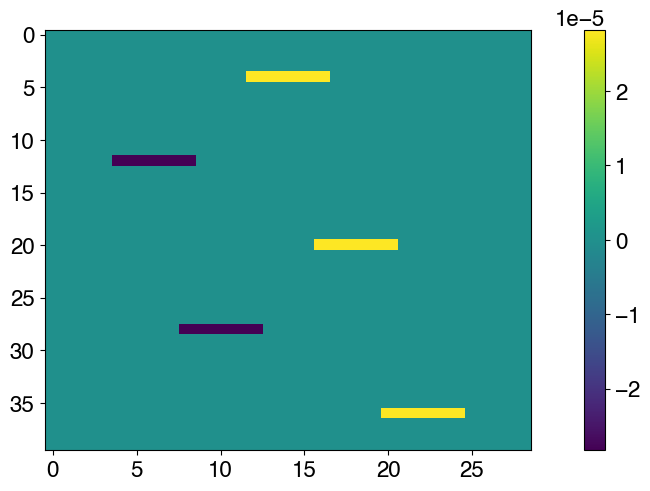

In [16]:
plt.imshow(model_estimate.fl_model.unitflow[:, 0, :], aspect="auto")
plt.colorbar()

- Top view

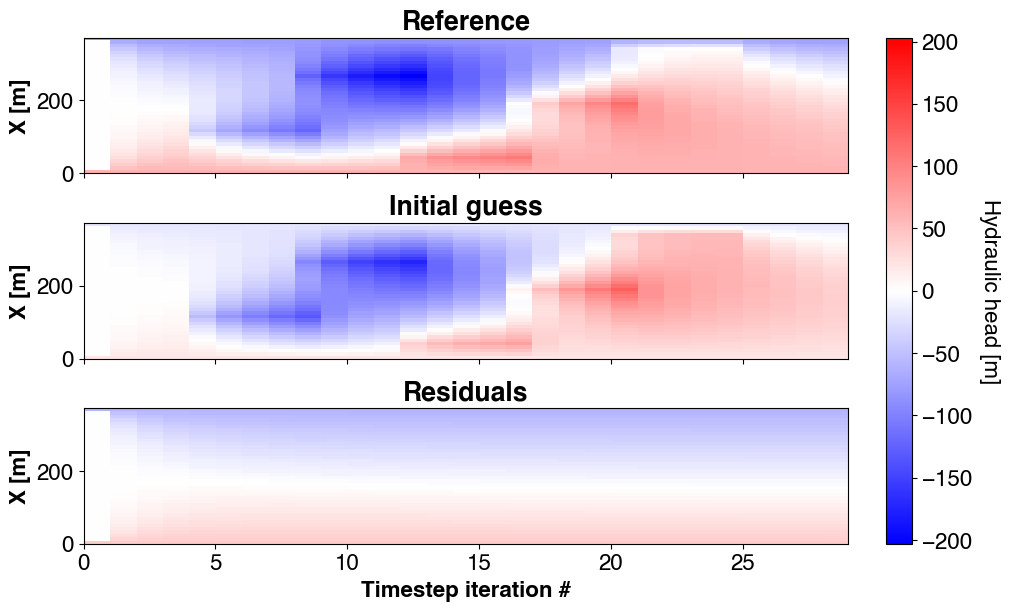

In [17]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 6)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]],
            sharey=True,
            sharex=True,
        )
    },
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "Reference": model_reference.fl_model.head[:, 0, :].T,
        "Initial guess": model_estimate.fl_model.head[:, 0, :].T,
        "Residuals": (
            model_reference.fl_model.head[:, 0, :].T
            - model_estimate.fl_model.head[:, 0, :].T
        ),
    },
    cbar_title="Hydraulic head [m]",
    ylabel="X [m]",
    is_symmetric_cbar=True,
    imshow_kwargs={
        # "cmap": plt.get_cmap("jet"),
        "extent": [0.0, model_reference.time_params.nt, 0.0, nx * dx],
    },
)

plotter.get_axis("ax3-1").set_xlabel("Timestep iteration #", fontweight="bold")

fname = "head_ref_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Forward variables at the producer locations

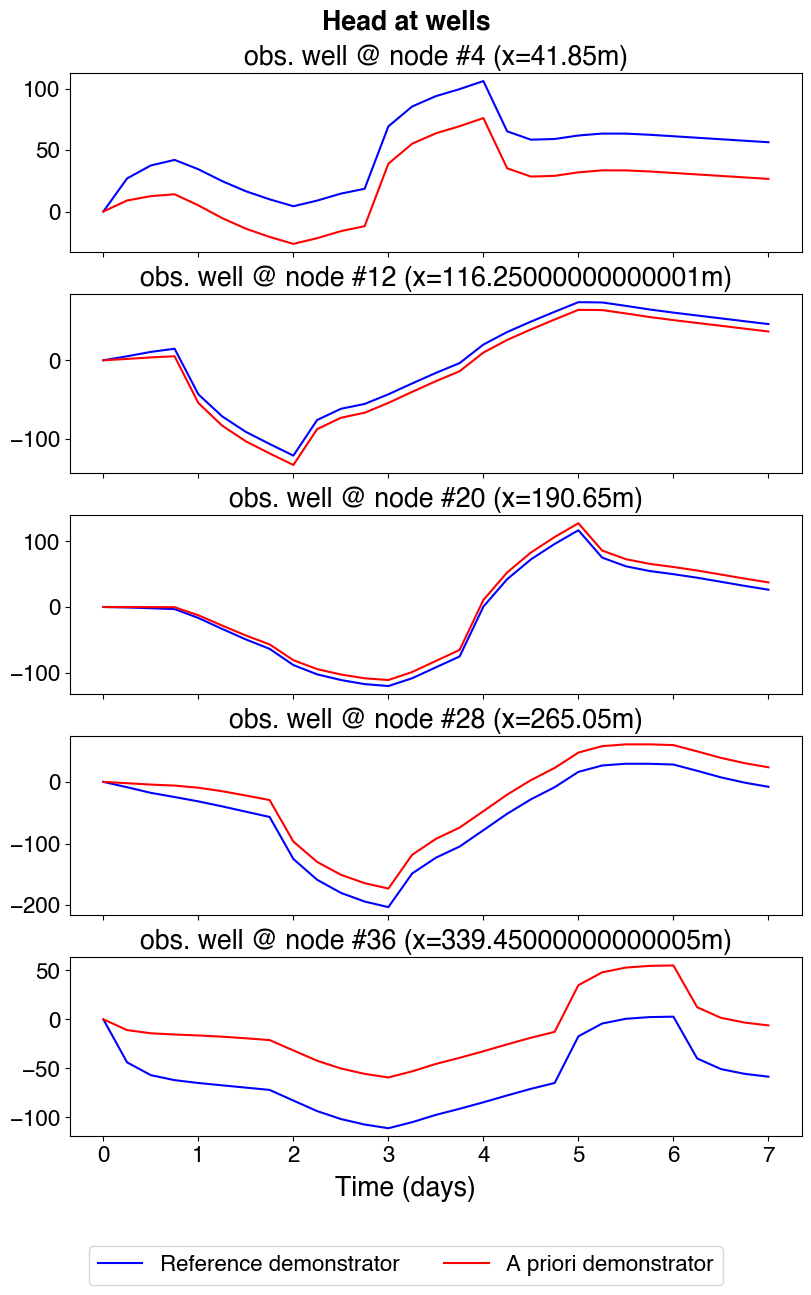

In [18]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 12)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"], ["ax4-1"], ["ax5-1"]],
            sharey=False,
            sharex=True,
        )
    },
)

for i, node_id in enumerate(sorted(production_locations + injection_locations)):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        model_reference.time_params.times / 3600 / 24,
        model_reference.fl_model.head[node_id, 0, :],
        label="Reference demonstrator",
        c="b",
    )
    ax.plot(
        model_estimate.time_params.times / 3600 / 24,
        model_estimate.fl_model.head[node_id, 0, :],
        label="A priori demonstrator",
        c="r",
    )

plotter.fig.supxlabel("Time (days)")
plotter.fig.suptitle("Head at wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=0.0)

fname = "head_ref_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [19]:
# function for time display
# plot the time
def get_time(nb_frames: int) -> Generator[str, None, None]:
    ts_btw_frames = model_estimate.time_params.nt / nb_frames
    for frame in range(nb_frames):
        yield f"time = {model_estimate.time_params.times[int(ts_btw_frames * frame)] / 3600:.3f} h"

In [20]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (6, 5)},
    subplots_mosaic_params={"fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True)},
)

# Animated plot
nb_frames = min(20, model_reference.time_params.nt)

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "True": {
            "x": x_coordinates,
            "y": model_reference.fl_model.head[:, 0, :],
            "kwargs": {"c": "blue"},
        },
        "Estimated": {
            "x": x_coordinates,
            "y": model_estimate.fl_model.head[:, 0, :],
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
    title="Pyrtid",
    xlabel="X [m]",
)

for ax_name in ["ax1-1"]:
    # Add some vertical lines to indicate the well
    for well_pos in production_locations:
        plotter.get_axis(ax_name).plot(
            (well_pos + 1) * dx
            - dx / 2,  # Well pos + 1 because of indexing that starts at zero
            0.0,
            label="prod wells",
            marker="^",
            markersize=10,
            c="r",
            linestyle="none",
        )

    for well_pos in injection_locations:
        plotter.get_axis(ax_name).plot(
            (well_pos + 1) * dx - dx / 2,
            0.0,
            label="inj wells",
            marker="^",
            markersize=10,
            c="g",
            linestyle="none",
        )

    plotter.plot_animated_text(
        ax=plotter.get_axis(ax_name),
        x=0.83,
        y=0.92,
        s=list(get_time(nb_frames)),
        horizontalalignment="center",
        verticalalignment="center",
        transform=plotter.get_axis(ax_name).transAxes,
        fontsize=14,
        fontweight="bold",
    )

    plotter.add_axis_legend(ax_name, loc="upper left")

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("true_vs_estimate_conc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


## Inversion

We sample heads in the first half of the simulation, and pressure in the second half of the simulation so we can test the implementation with both. We also add a small overlap (2 observations).


In [21]:
freq_measure_in_d = 0.5  # one measure every two days
n_sampled_days = duration_in_d / freq_measure_in_d

obs_times_in_s = np.arange(n_sampled_days) * 3600 * 24 * freq_measure_in_d
obs_times_in_s_head = obs_times_in_s

logging.info(f"obs_times_in_s_head = {obs_times_in_s_head}")

INFO:root:obs_times_in_s_head = [     0.  43200.  86400. 129600. 172800. 216000. 259200. 302400. 345600.
 388800. 432000. 475200. 518400. 561600.]


In [22]:
noise_std_head: float = 3.0  # This is an absolute value in m


def get_white_noise(shape: Iterable[int], noise_std: float) -> NDArrayFloat:
    """
    Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return np.random.default_rng(2021).normal(
        mean_noise, noise_std, size=np.array(shape)
    )


# Generate a white noise
obs_noise_head: NDArrayFloat = get_white_noise(
    (len(production_locations), obs_times_in_s_head.size), noise_std_head
)

- Check the intensity of the noise for the head

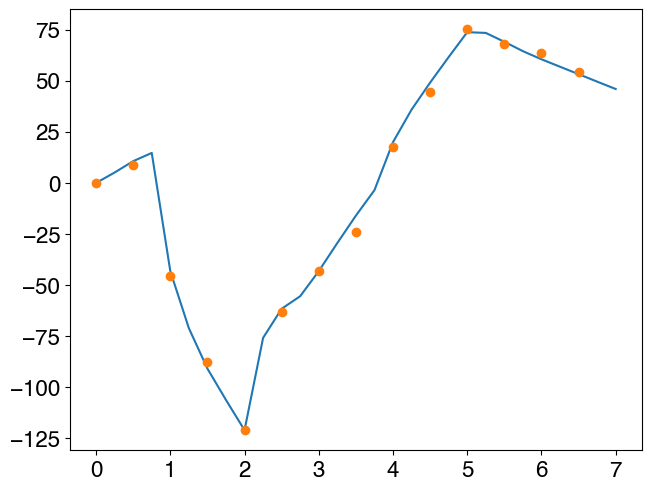

In [23]:
all_times = model_estimate.time_params.times

obs_values_head = np.zeros((len(production_locations), obs_times_in_s_head.size))

for count, ix in enumerate(production_locations):
    # interpolate the values
    obs_values_head[count] = (
        sp.interpolate.interp1d(
            all_times, model_reference.fl_model.head[ix, 0, :], kind="cubic"
        )(obs_times_in_s_head)
        + obs_noise_head[count, :]
    )

count = 0

ix = production_locations[count]
plt.plot(all_times / 3600 / 24, model_reference.fl_model.head[ix, 0, :])
plt.plot(
    obs_times_in_s_head / 3600 / 24,
    obs_values_head[count],
    marker="o",
    linestyle="none",
)

## Gradient with respect to the storage coefficient


In [24]:
import copy

In [25]:
param_1 = dminv.AdjustableParameter(
    name=dminv.ParameterName.INITIAL_HEAD,
    # /10 to avoid finite differences fail because of bounds clipping
    lbounds=-100,
    ubounds=+100,
)
param_1_w = copy.deepcopy(param_1)

observables = []
for i, node_id in enumerate(production_locations):
    observables.append(
        pyrtid.inverse.Observable(
            state_variable=pyrtid.inverse.StateVariable.HEAD,
            node_indices=node_id,
            times=obs_times_in_s_head,
            values=obs_values_head[i],
            uncertainties=noise_std_head,
        )
    )

# Create an executor to keep track of the adjoint model
solver_config = dminv.ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 10, "maxiter": 10, "ftol": 1e-3, "gtol": 1e-3},
    is_check_gradient=False,
    is_adj_numerical_acceleration=True,
    afpi_eps=1e-15,
)
model_adjusted_1 = copy.deepcopy(model_estimate)
inverse_model_1 = dminv.InverseModel(param_1, observables)
executor_1 = dminv.ScipyInversionExecutor(
    model_adjusted_1, inverse_model_1, solver_config
)

executor_1.eval_scaled_loss(param_1.preconditioner(param_1.values), is_save_state=False)

is_grad_ok = executor_1.is_adjoint_gradient_correct(
    max_workers=4, is_verbose=False, eps=1e-6
)

INFO:root:- Running forward model # 1


INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 665.4574768026861
INFO:root:Loss (obs fit) / Nobs = 23.76633845723879
INFO:root:Loss (regularization) = 0.0
INFO:root:Scaling factor        = 0.0015027256208836747
INFO:root:Loss (scaled)         = 1.0



In [26]:
logging.info(f"Is the gradient correct: {is_grad_ok}")

INFO:root:Is the gradient correct: True


In [27]:
param1_grad_init_adj = param_1.grad_adj_history[0]
param1_grad_init_fd = param_1.grad_fd_history[0]

In [28]:
model_adjusted_1_w = copy.deepcopy(model_estimate)
inverse_model_1_w = dminv.InverseModel(param_1_w, observables)
executor_1_w = dminv.ScipyInversionExecutor(
    model_adjusted_1_w, inverse_model_1_w, solver_config
)

executor_1_w.eval_scaled_loss(
    param_1_w.preconditioner(param_1_w.values), is_save_state=False
)
executor_1_w.adj_model.a_fl_model.set_crank_nicolson(0.5)

is_grad_1_w_ok = executor_1_w.is_adjoint_gradient_correct(
    max_workers=4, is_verbose=False
)

INFO:root:- Running forward model # 1


INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 665.4574768026861
INFO:root:Loss (obs fit) / Nobs = 23.76633845723879
INFO:root:Loss (regularization) = 0.0
INFO:root:Scaling factor        = 0.0015027256208836747
INFO:root:Loss (scaled)         = 1.0



In [29]:
logging.info(f"Is the gradient correct: {is_grad_1_w_ok}")

INFO:root:Is the gradient correct: False


### Results comparison

The adjoint concentrations should be quite the same both in shape and intensity.

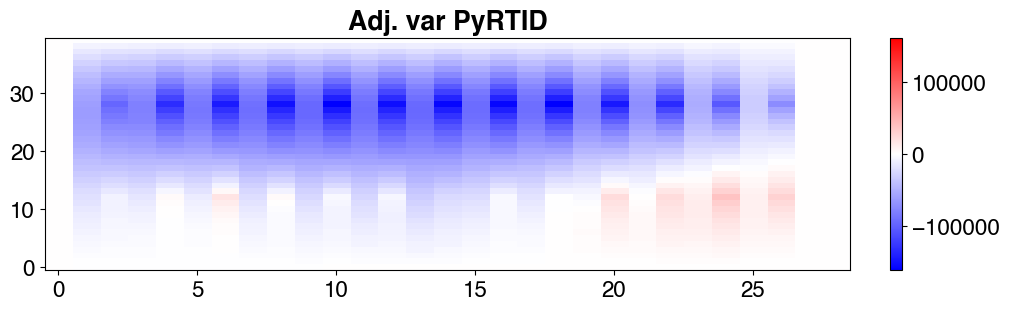

In [30]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 3)},
    subplots_mosaic_params={"fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True)},
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "Adj. var PyRTID": executor_1.adj_model.a_fl_model.a_head[:, 0, :].T,
    },
    is_symmetric_cbar=True,
)

fname = "adjoint_concentrations_dem_vs_hytec_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

Let's check the adjoint variables at the three observation wells. Note that only the right one has been used as an adjoint source (node_id == 15).

- Get the gradients by the adjoint method and finite differences

Finally, plot the gradients comparison.

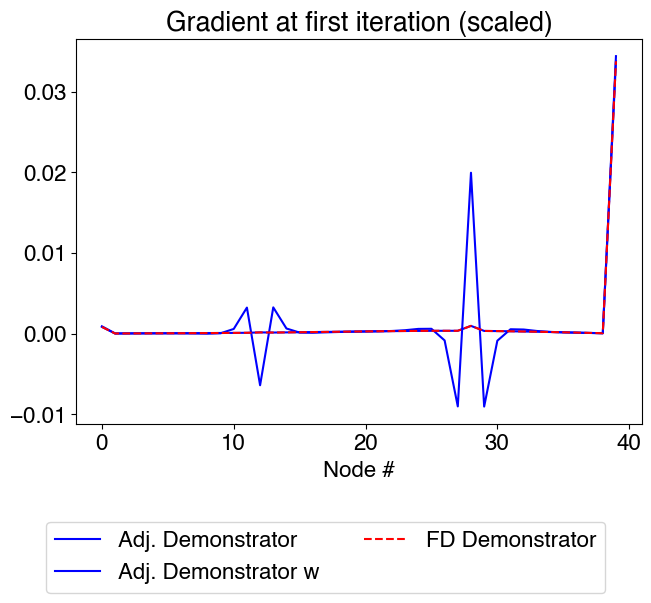

In [31]:
# Here comes the python code
plotter = ngp.NestedGridPlotter()
# The gradient saved by HYTEC takes into account the scaling factor. See if it is required or not ??? -> yes for the hessian

ax = plotter.get_axis("ax1-1")

# Demonstrator (PyRTID)
ax.plot(
    param_1.grad_adj_history[0] * executor_1.inv_model.scaling_factor,
    label="Adj. Demonstrator",
    c="b",
)
ax.plot(
    param_1_w.grad_adj_history[0] * executor_1_w.inv_model.scaling_factor,
    label="Adj. Demonstrator w",
    c="b",
)
ax.plot(
    param_1.grad_fd_history[0] * executor_1.inv_model.scaling_factor,
    label="FD Demonstrator",
    c="r",
    linestyle="--",
)

ax.set_title("Gradient at first iteration (scaled)")
ax.set_xlabel("Node #")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_sc"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [32]:
param_1_w.grad_adj_history[0] / param_1.grad_fd_history[0]

array([  1.08654362,   1.36772144,   1.31710286,   1.23004008,
         1.10063233,   0.90814828,   0.60785101,   0.15752219,
        -0.27749643,   0.48542708,   7.18168274,  35.04120568,
       -45.51596212,  26.31921569,   4.40183087,   0.72826279,
         0.5307232 ,   0.72968102,   0.8591196 ,   0.91633835,
         0.94025683,   0.96811877,   1.0595624 ,   1.31209236,
         1.75916383,   1.75346222,  -2.49906289, -26.45050282,
        21.00243075, -28.04121682,  -2.93282159,   1.89901696,
         1.97662709,   1.43535293,   1.08947013,   0.94795839,
         0.90941587,   0.90674189,   0.91083693,   1.01874576])

In [33]:
param_1.grad_adj_history[0] / param_1.grad_fd_history[0]

array([1.00000083, 0.99968288, 1.00015938, 1.00012191, 1.00007169,
       1.00003532, 1.00004024, 1.00003785, 0.99999706, 0.99996381,
       0.99997114, 1.00000835, 0.99997413, 1.00001592, 0.99999848,
       0.99999884, 1.00000458, 0.99999467, 0.99999861, 1.00000343,
       0.99998454, 0.99998717, 1.00000701, 1.00000483, 1.00000519,
       0.99998283, 0.99999753, 0.99999101, 1.00000008, 0.99999436,
       0.99999847, 1.00000237, 0.99998816, 0.99997816, 0.99998671,
       1.00001842, 1.00001533, 1.00001464, 0.99995876, 0.99999998])

- Plot the residuals: note in HYTEC we have zero probably because of the number of digits used to save the gradient

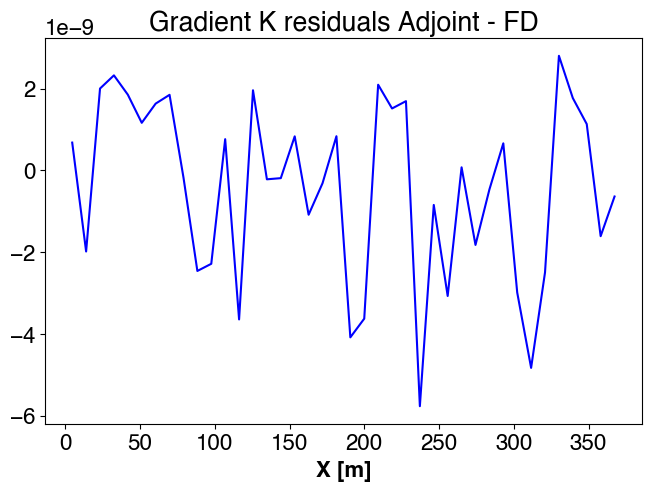

In [34]:
# Here comes the python code
plt.rcParams["text.usetex"] = False
plotter = ngp.NestedGridPlotter()
# The gradient saved by HYTEC takes into account the scaling factor. See if it is required or not ??? -> yes for the hessian

ax = plotter.get_axis("ax1-1")

# Demonstrator (PyRTID)
ax.plot(
    x_coordinates,
    (param_1.grad_adj_history[0] - param_1.grad_fd_history[0])
    * executor_1.inv_model.scaling_factor,
    # label="Residuals Adjoint - Demonstrator",
    c="b",
)

# ax.set_title("Gradient at first iteration (scaled)")
ax.set_title(r"Gradient K residuals Adjoint - FD")
ax.set_xlabel("X [m]", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_K_residuals_adjoint_fd"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)
plt.rcParams["text.usetex"] = False

In [35]:
res = executor_1.run()

INFO:root:============================= Inversion Parameters =============================
INFO:root:Method                                            : L-BFGS-B
INFO:root:
INFO:root:Number of adjusted parameters                     : 1
INFO:root:Number of unknowns (adjusted values)              : 40
INFO:root:Number of observables                             : 2
INFO:root:Number of observation data points (values)        : 28
INFO:root:================================================================================
INFO:root:Entering optimization loop: 1
INFO:root:- Running forward model # 1
INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 665.4574768026861
INFO:root:Loss (obs fit) / Nobs = 23.76633845723879
INFO:root:Loss (regularization) = 0.0
INFO:root:Scaling factor        = 0.0015027256208836747
INFO:root:Loss (scaled)         = 1.0

INFO:root:- Running gradient # 1
INFO:root:- Gradient eval # 1 over

INFO:root:- Running forward model # 2
INFO:root:- Run # 2 over
INFO:r

In [36]:
res = executor_1_w.run()

INFO:root:============================= Inversion Parameters =============================
INFO:root:Method                                            : L-BFGS-B
INFO:root:
INFO:root:Number of adjusted parameters                     : 1
INFO:root:Number of unknowns (adjusted values)              : 40
INFO:root:Number of observables                             : 2
INFO:root:Number of observation data points (values)        : 28
INFO:root:================================================================================
INFO:root:Entering optimization loop: 1
INFO:root:- Running forward model # 1
INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 665.4574768026861
INFO:root:Loss (obs fit) / Nobs = 23.76633845723879
INFO:root:Loss (regularization) = 0.0
INFO:root:Scaling factor        = 0.0015027256208836747
INFO:root:Loss (scaled)         = 1.0

INFO:root:- Running gradient # 1
INFO:root:- Gradient eval # 1 over

INFO:root:- Running forward model # 2
INFO:root:- Run # 2 over
INFO:r

In [37]:
executor_1_w.inv_model.loss_scaled_history

[1.0,
 0.9988252534825885,
 0.21230430755262733,
 0.14428000271137037,
 0.0966755716872307,
 0.055932808343261066,
 0.06031656615711979,
 0.05174178679689306,
 0.04761092818976045,
 0.025100411396382995,
 0.0271218526452348,
 0.01835370922401]

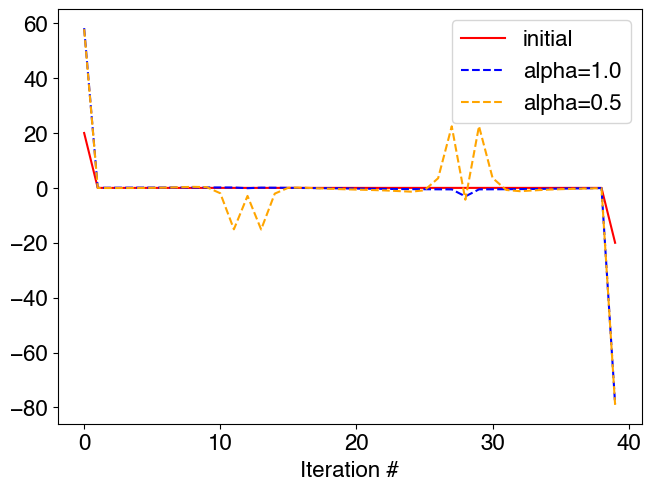

In [38]:
plotter = ngp.NestedGridPlotter()
# The gradient saved by HYTEC takes into account the scaling factor. See if it is required or not ??? -> yes for the hessian

ax = plotter.get_axis("ax1-1")

ax.plot(model_estimate.fl_model.lhead[0], c="r", label="initial")
ax.plot(param_1.values, c="b", label="alpha=1.0", linestyle="--")
ax.plot(param_1_w.values, c="orange", label="alpha=0.5", linestyle="--")

# ax.set_title("Cost function values")
ax.set_xlabel("Iteration #")

ax.legend()

fname = "adjusted_perm"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

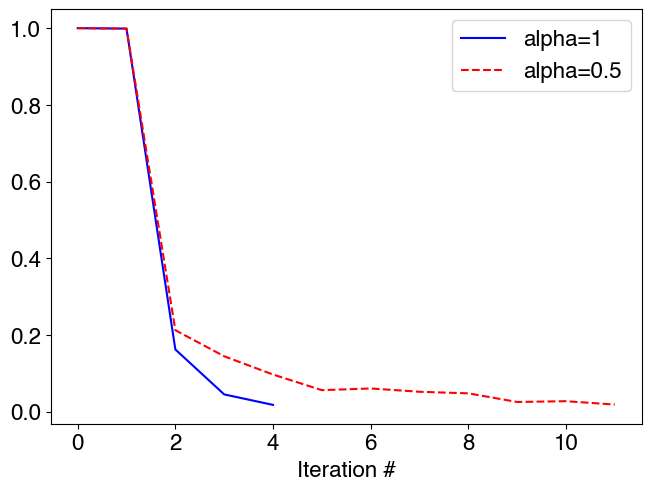

In [39]:
plotter = ngp.NestedGridPlotter()
# The gradient saved by HYTEC takes into account the scaling factor. See if it is required or not ??? -> yes for the hessian

ax = plotter.get_axis("ax1-1")

ax.plot(executor_1.inv_model.loss_scaled_history, c="b", label="alpha=1")
ax.plot(
    executor_1_w.inv_model.loss_scaled_history, c="r", label="alpha=0.5", linestyle="--"
)

# ax.set_title("Cost function values")
ax.set_xlabel("Iteration #")

ax.legend()

fname = "cost_function_values"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

## Figure for the article

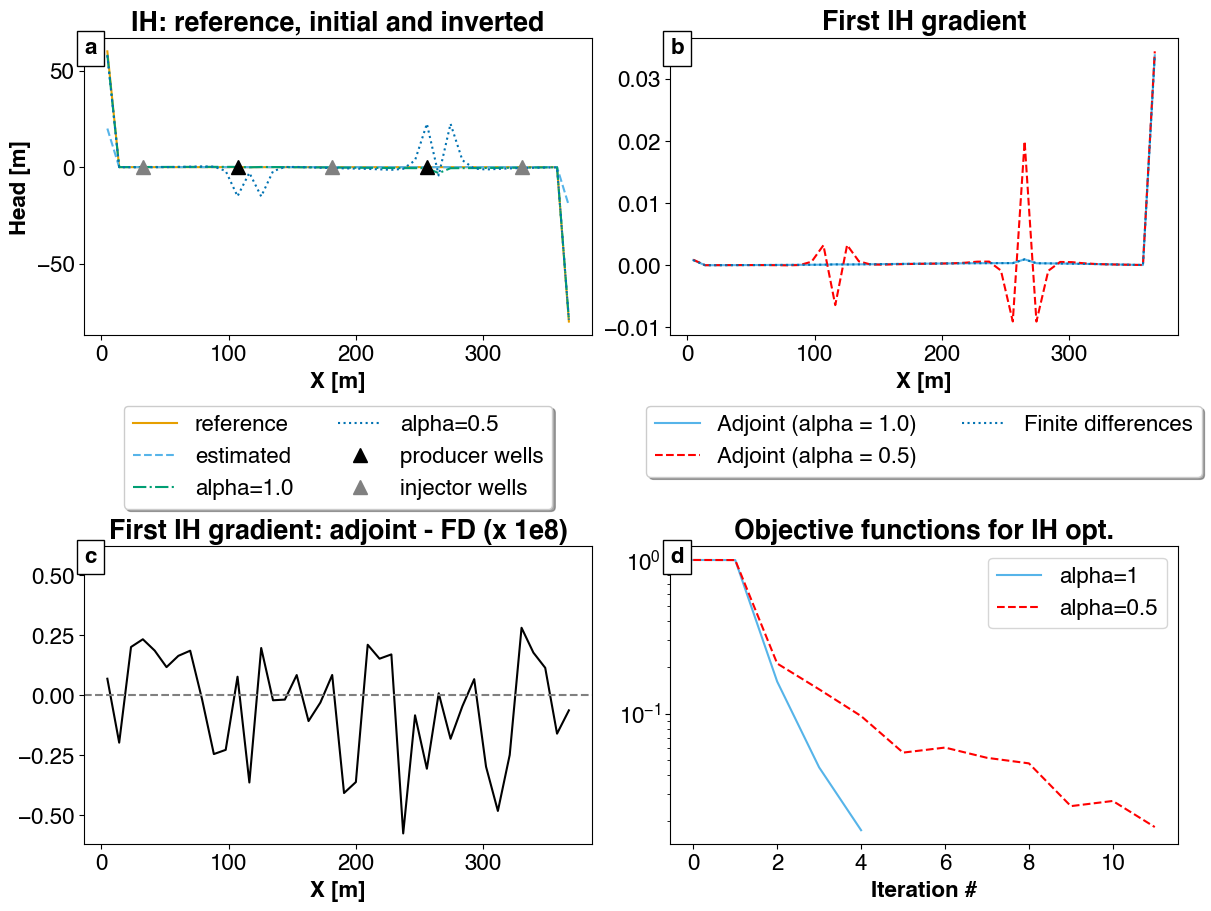

In [40]:
plt.rcParams["text.usetex"] = False


from cycler import cycler

line_cycler = cycler(
    color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]
) + cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."])
marker_cycler = (
    cycler(
        color=[
            "#E69F00",
            "#56B4E9",
            "#009E73",
            "#0072B2",
            "#D55E00",
            "#CC79A7",
            "#F0E442",
        ]
    )
    + cycler(linestyle=["none", "none", "none", "none", "none", "none", "none"])
    + cycler(marker=["4", "2", "3", "1", "+", "x", "."])
)

plt.rc("axes", prop_cycle=line_cycler)

# Here comes the python code
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 9)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2"], ["ax2-1", "ax2-2"]],
            sharey=False,
            sharex=False,
        )
    },
)

####

# 1) Hydraulic conductivity field and well positions
ax = plotter.get_axis("ax1-1")
ax.set_prop_cycle(line_cycler)

# Plot conductivity
ax.plot(x_positions_in_meters, model_reference.fl_model.lhead[0], label="reference")
ax.plot(x_positions_in_meters, model_estimate.fl_model.lhead[0], label="estimated")
ax.plot(x_positions_in_meters, param_1.values, label="alpha=1.0")
ax.plot(x_positions_in_meters, param_1_w.values, label="alpha=0.5")

# Add wells
for well_pos in production_locations:
    ax.plot(
        well_pos * dx - dx / 2,
        0,
        label="producer wells",
        marker="^",
        markersize=10,
        c="k",
        linestyle="none",
    )

for well_pos in injection_locations:
    ax.plot(
        well_pos * dx - dx / 2,
        0,
        label="injector wells",
        marker="^",
        markersize=10,
        c="grey",
        linestyle="none",
    )
ax.set_title("IH: reference, initial and inverted", fontweight="bold")
ax.set_xlabel("X [m]", fontweight="bold")
ax.set_ylabel("Head [m]", fontweight="bold")
plotter.add_axis_legend(
    "ax1-1",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    fancybox=True,
    shadow=True,
    ncol=2,
)

####

# Ax 2 : gradient with respct to the hydraulic conductivity.
ax = plotter.get_axis("ax1-2")
ax.plot(
    x_coordinates,
    param_1.grad_adj_history[0] * executor_1.inv_model.scaling_factor,
    label=r"Adjoint (alpha = 1.0)",
    c="#56B4E9",
)
ax.plot(
    x_coordinates,
    param_1_w.grad_adj_history[0] * executor_1_w.inv_model.scaling_factor,
    label=r"Adjoint (alpha = 0.5)",
    # c="#E69F00",
    c="r",
    linestyle="--",
)
ax.plot(
    x_coordinates,
    param1_grad_init_fd * executor_1.inv_model.scaling_factor,
    label=r"Finite differences",
    c="#0072B2",
    linestyle=":",
)
ax.set_title("First IH gradient", fontweight="bold")
# ax.set_title(r"$\frac{\partial \mathcal{J}}{\partial K_{i}}$ at first iteration (scaled)")
ax.set_xlabel(r"X [m]", fontweight="bold")
ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=2
)

####

# Ax 3 : hc gradient residuals: adjoint-fd
ax = plotter.get_axis("ax2-1")
ax.plot(
    x_coordinates,
    (param_1.grad_adj_history[0] - param1_grad_init_fd)
    * executor_1.inv_model.scaling_factor
    * 1e8,
    # label="Residuals Adjoint - Demonstrator",
    c="k",
)
ax.axhline(y=0.0, linestyle="--", c="grey")
make_y_axes_symmetric_zero_centered([ax])
ax.set_xlabel(r"X [m]", fontweight="bold")
ax.set_title("First IH gradient: adjoint - FD (x 1e8)", fontweight="bold")

####

# Ax 4 : objective function
ax = plotter.get_axis("ax2-2")
ax.plot(executor_1.inv_model.loss_scaled_history, label="alpha=1", c="#56B4E9")
ax.plot(
    executor_1_w.inv_model.loss_scaled_history, label="alpha=0.5", linestyle="--", c="r"
)
# ax.set_title("Cost function values")
ax.set_xlabel("Iteration #", fontweight="bold")
ax.legend()
ax.set_yscale("log")
ax.set_title("Objective functions for IH opt.", fontweight="bold")


# plotter.add_fig_legend(ncol=3, bbox_y_shift=-0.0)

# Finally: add a letter to each frame
ngp.add_letter_to_frames(plotter.axes)

fname = "fig_4_frames"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)